In [148]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [149]:
N = 256
P = 50

T_STEP = int(P/3) + 1 # number of step to divide transformation process
I_STEP = int(N/6) # number of step to divide inverse transformation process

ori_img = cv2.imread('./maudy.png', 0)
img = cv2.resize(ori_img, (N,N))
imvec = np.reshape(np.array(img), (N*N,1))

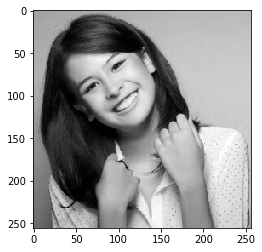

In [150]:
def imshow(imgdata):
    plt.imshow(imgdata, cmap = 'gray')
    plt.show()

imshow(img)

In [151]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [ ]:
def translateIndex(index):
    return (2 * index - N + 1) / (N - 1) / np.sqrt(2)

In [ ]:
transformed = np.array([])

# GENERATE MATRIX TRANSFORM

t_len = 2 * P + 1

vecN = np.ones((t_len, t_len), dtype='float32')
vecM = np.ones((t_len, t_len), dtype='float32')
for i in range(-P, P+1):
    vecN[i + P, :] = i
    vecM[:, i + P] = i
vecN = vecN.reshape((t_len * t_len, 1))
vecM = vecM.reshape((t_len * t_len, 1))

vecI = np.ones((N, N), dtype='float32')
vecK = np.ones((N, N), dtype='float32')
for i in range(N):
    vecI[i,:] = i
    vecK[:,i] = i
vecI = vecI.reshape((1, N * N))
vecK = vecK.reshape((1, N * N))

vecY = translateIndex(vecI)
vecX = translateIndex(vecK)
vecR = np.sqrt(vecX * vecX + vecY * vecY)
vecT = np.arctan2(vecY, vecX)

# FREE UP SOME MEMORY - 1
del vecI
del vecK
del vecY
del vecX

update_progress(0)
for row in range(int(np.ceil(t_len / T_STEP))):
    start = row * T_STEP * t_len
    end = np.min([row * T_STEP + T_STEP, t_len]) * t_len
    matR = np.repeat(vecR, end - start, axis=0)
    matT = np.repeat(vecT, end - start, axis=0)
    matN = np.repeat(vecN[start:end, :], N * N, axis=1)
    matM = np.repeat(vecM[start:end, :], N * N, axis=1)
    
    matW = 2 / (np.pi * N * N) * np.exp(-2 * np.pi * matN * matR * matR * 1j - matM * matT * 1j)
    trf_row = np.matmul(matW, imvec)
    transformed = np.append(transformed, trf_row)

    # FREE UP SOME MEMORY - 2
    del matW
    del matN
    del matM
    del matR
    del matT
    
    update_progress((row * T_STEP + T_STEP) / t_len)

update_progress(1)

Progress: [####################] 100.0%


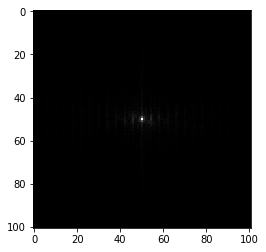

In [ ]:
transformed_abs = np.abs(transformed)
transformed_abs_img = np.reshape(transformed_abs, (2 * P + 1, 2 * P + 1))
imshow(transformed_abs_img)

In [ ]:
inversed = np.array([])

# GENERATE MATRIX INVERS TRANSFORM

t_len = 2 * P + 1

vecN = np.ones((t_len, t_len), dtype='float32')
vecM = np.ones((t_len, t_len), dtype='float32')
for i in range(-P, P+1):
    vecN[i + P, :] = i
    vecM[:, i + P] = i
vecN = vecN.reshape((1, t_len * t_len))
vecM = vecM.reshape((1, t_len * t_len))

vecI = np.ones((N, N), dtype='float32')
vecK = np.ones((N, N), dtype='float32')
for i in range(N):
    vecI[i,:] = i
    vecK[:,i] = i
vecI = vecI.reshape((N * N, 1))
vecK = vecK.reshape((N * N, 1))

vecY = translateIndex(vecI)
vecX = translateIndex(vecK)
vecR = np.sqrt(vecX * vecX + vecY * vecY)
vecT = np.arctan2(vecY, vecX)

# FREE UP SOME MEMORY - 1
del vecI
del vecK
del vecY
del vecX

update_progress(0)
for row in range(int(np.ceil(N / I_STEP))):
    start = row * I_STEP * N
    end = np.min([row * I_STEP + I_STEP, N]) * N
    matR = np.repeat(vecR[start:end, :], t_len * t_len, axis=1)
    matT = np.repeat(vecT[start:end, :], t_len * t_len, axis=1)
    matN = np.repeat(vecN, end - start, axis=0)
    matM = np.repeat(vecM, end - start, axis=0)
    
    matV = np.exp(2 * np.pi * matN * matR * matR * 1j + matM * matT * 1j)
    inv_row = np.matmul(matV, transformed)
    inversed = np.append(inversed, inv_row)

    # FREE UP SOME MEMORY - 2
    del matV
    del matN
    del matM
    del matR
    del matT
    
    update_progress((row * I_STEP + I_STEP) / N)

update_progress(1)

Progress: [##########----------] 49.2%


In [ ]:
inversed_abs = np.abs(inversed)
inversed_abs_img = np.reshape(inversed_abs, (N,N))
imshow(inversed_abs_img)

In [ ]:
np.max(inversed_abs)

In [ ]:
np.min(inversed_abs)